# CS579: Lecture 05  
** Community Detection **

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

(Many figures come from [Mining of Massive Datasets](http://www.mmds.org/), Jure Leskovec, Anand Rajaraman, Jeff Ullman)

![network](network.png)

- **Why do we want to identify communities?**
- **What are the "communities" in this graph?**
- **Why did you choose these communities?**

<br><br><br><br><br>

**A bad solution: Agglomerative clustering**

- Let distance function $d(A,B)$ be the shortest path between nodes $A$ and $B$
- Let $C_i$ and $C_j$ be two clusters of nodes. Then, let the distance between two clusters be the minimum distance of any two nodes: $d(C_i, C_j) = \min_{X \in C_i, Y \in C_j} \hspace{.1cm} d(X, Y)$
- Greedy agglomerative clustering iterative merges the closest two clusters 

<img width=200 src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Hierarchical_clustering_simple_diagram.svg">

**What would agglomerative clustering do on this network? **

![network](network.png)

$d(A,B) = d(A,C) = d(B, C) = d(B,D) = d(D,E) = d(D,F) = d(D,G) = d(E,F) = d(G,F) = 1$

$d(A,D) = d(C,D) ... = 2$

<br><br><br>
First merge: sample randomly from all nodes with distance == 1.


<br><br><br>
So, $\frac{1}{9}$ chance we merge $B$ and $D$ in first merge.

Not desireable...any other ideas?

What makes the edge between $B$ and $D$ special?

**Betweenness:** The betweenness of an edge $(A, B)$ is the fraction of shortest paths between any nodex $X$ and $Y$ that include edge $(A, B)$.

High betweenness $\rightarrow$ $A$ and $B$ belong in different communities.

![network](network.png)

What is **betweenness** of $(B,D)$?

Of $(D,F)$?

![network](network.png)

What is **betweenness** of $(B,D)$? 

> $(B,D)$ is on all shortest paths connecting any of $\{A,B,C\}$ to any of $\{D,E,F,G\}$.

> Thus, total number of shortest paths = number passing through $(B,D)$ =  $3 * 4 = \mathbf{12}.$. So, $bt(B,D) = 12$

Of $(D,F)$?

> $(D,F)$ is on shortest paths from $\{A,B,C,D\}$ to $\{F\}$.

> Thus, betweenness is $4 * 1 = \mathbf{4}.$



$$
bt(e) =\sum_{s,t \in V} \frac{\sigma(s, t|e)}{\sigma(s, t)}
$$
where

- $V$ is the set of nodes
- $\sigma(s, t)$ is the number of shortest paths between nodes $s$ and $t$
- $\sigma(s, t|e)$ is the number of those paths  passing through some  edge $e$ 

If $s = t$, $\sigma(s, t) = 1$, and if $v \in {s, t}$,
    $\sigma(s, t|e) = 0$.

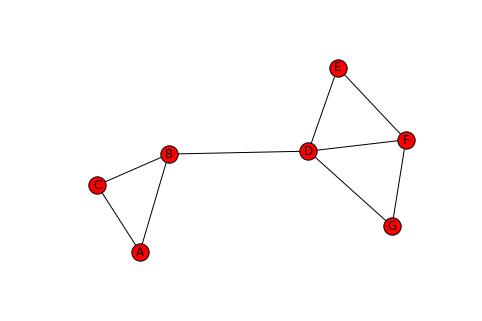

In [23]:
import networkx as nx
%matplotlib inline
def create_example_graph():
    graph = nx.Graph()
    graph.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'C'),
                          ('B', 'D'), ('D', 'E'), ('D', 'F'),
                          ('D', 'G'), ('E', 'F'), ('G', 'F')])
    return graph

graph = create_example_graph()
nx.draw(graph, with_labels=True)

In [24]:
# We'll use networkx's built-in betweenness computation in this example.
nx.edge_betweenness_centrality(graph, normalized=False)
# nx.edge_betweenness_centrality(graph, normalized=True)
# normalized between 0-1

{('A', 'B'): 5.0,
 ('A', 'C'): 1.0,
 ('B', 'C'): 5.0,
 ('D', 'B'): 12.0,
 ('D', 'E'): 4.5,
 ('D', 'F'): 4.0,
 ('F', 'E'): 1.5,
 ('G', 'D'): 4.5,
 ('G', 'F'): 1.5}

** How to compute shortest path in undirected graph? **

<br><br><br>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/46/Animated_BFS.gif">

[source](https://en.wikipedia.org/wiki/File:Animated_BFS.gif)

In [25]:
from networkx.algorithms.centrality.betweenness import _single_source_shortest_path_basic

for s in graph.nodes():
    S, P, sigma = _single_source_shortest_path_basic(graph, s)
    print('\nshortest path lengths for %s' % s)
    print(sigma)
    print('nodes traversed on shortest paths')
    print(P)


shortest path lengths for G
{'G': 1.0, 'D': 1.0, 'F': 1.0, 'A': 1.0, 'B': 1.0, 'C': 1.0, 'E': 2.0}
nodes traversed on shortest paths
{'G': [], 'D': ['G'], 'F': ['G'], 'A': ['B'], 'B': ['D'], 'C': ['B'], 'E': ['D', 'F']}

shortest path lengths for D
{'G': 1.0, 'D': 1.0, 'F': 1.0, 'A': 1.0, 'B': 1.0, 'C': 1.0, 'E': 1.0}
nodes traversed on shortest paths
{'G': ['D'], 'D': [], 'F': ['D'], 'A': ['B'], 'B': ['D'], 'C': ['B'], 'E': ['D']}

shortest path lengths for F
{'G': 1.0, 'D': 1.0, 'F': 1.0, 'A': 1.0, 'B': 1.0, 'C': 1.0, 'E': 1.0}
nodes traversed on shortest paths
{'G': ['F'], 'D': ['F'], 'F': [], 'A': ['B'], 'B': ['D'], 'C': ['B'], 'E': ['F']}

shortest path lengths for A
{'G': 1.0, 'D': 1.0, 'F': 1.0, 'A': 1.0, 'B': 1.0, 'C': 1.0, 'E': 1.0}
nodes traversed on shortest paths
{'G': ['D'], 'D': ['B'], 'F': ['D'], 'A': [], 'B': ['A'], 'C': ['A'], 'E': ['D']}

shortest path lengths for B
{'G': 1.0, 'D': 1.0, 'F': 1.0, 'A': 1.0, 'B': 1.0, 'C': 1.0, 'E': 1.0}
nodes traversed on shortest pat

# Girvan-Newman Algorithm

**Input:** Graph $G$; desired number of clusters $k$

- **While** number of clusters $< k$:
  - Compute the betweenness of all edges in $G$
  - Remove edge with highest betweenness


![between](between.png)

![between2](between2.png)

## Computing betweenness of all edges

- All pairs-shortest-paths, but need to store the paths.
- How can we reduce redundant computation?

## Computing betweenness of all edges

![newman1](newman1.png)

1.) Do breadth-first search starting at node $E$.
  - Each level is length of shortest path from $E$ to that node
  - Edges within the same level cannot be part of a shortest path from $E$ to some target.
  
2.) Label each node by the number of shortest paths that reach it from the root.
  - Start by labeling the root ($E$). Then, each child node is the sum of its parents.
  - E.g., $G = D + F$


## Computing betweenness of all edges

![newman1](newman2.png)

3.) Compute fraction of shortest paths through each edge (bottom up).
  - leaf nodes get credit 1
  - non-leaf nodes get credit of 1 + credits for edges to nodes at level below
  - edges to level above gets credit proportional to fraction of shortest paths that go through it.

E.g. Level 3:
 - $A$ and $C$ are given credit 1 (they are leaf nodes)
 
Level 2:
 - $B$ gets credit $3$ ($A + C + 1$)
   - All shortest paths from  $\{E\}$ to $\{A, B, C\}$ go through B.
 - $G$ gets credit 1 (leaf)


## Computing betweenness of all edges

![newman1](newman3.png)

Level 1 Edges:
 - $D,B$ edge gets all credit from node $B$ (3)
 - $G$ has two parents, so edges $(D,G)$, $(F,G)$ share the credit from $G$
   - From step 1, $D$ and $F$ each have credit 1, so shared equally. $(\frac{1}{1+1} = .5)$
   - What if $D=5$, $F=3$?  $\frac{5}{8}$, $\frac{3}{8}$
    

Level 1 Nodes:
  - $D = 1 + 3 + .5 = 4.5$
  - $F = 1 + .5 = 1.5$

## Computing betweenness of all edges

![newman1](newman3.png)

- What if $D=5$, $F=3$?  


## Computing betweenness of all edges

![newman1](newman3.png)

- What if $D=5$, $F=3$?  
$(D,G) = \frac{5}{8}$, $(F,G) = \frac{3}{8}$

Final steps:

- Repeat for each node as source
- Divide total by 2 (since each shortest path found twice, once in each direction)

![between](between.png)

In [5]:
def girvan_newman(G, depth=0):
    """ Recursive implementation of the girvan_newman algorithm.
    See http://www-rohan.sdsu.edu/~gawron/python_for_ss/course_core/book_draft/Social_Networks/Networkx.html
    
    Args:
    G.....a networkx graph

    Returns:
    A list of all discovered communities,
    a list of lists of nodes. """

    if G.order() == 1:
        return [G.nodes()]
    
    def find_best_edge(G0):
        eb = nx.edge_betweenness_centrality(G0)
        # eb is dict of (edge, score) pairs, where higher is better
        # Return the edge with the highest score.
        return sorted(eb.items(), key=lambda x: x[1], reverse=True)[0][0]

    # Each component is a separate community. We cluster each of these.
    components = [c for c in nx.connected_component_subgraphs(G)]
    indent = '   ' * depth  # for printing
    while len(components) == 1:
        edge_to_remove = find_best_edge(G)
        print(indent + 'removing ' + str(edge_to_remove))
        G.remove_edge(*edge_to_remove)
        components = [c for c in nx.connected_component_subgraphs(G)]

    result = [c.nodes() for c in components]
    print(indent + 'components=' + str(result))
    for c in components:
        result.extend(girvan_newman(c, depth + 1))

    return result

In [6]:
result = girvan_newman(create_example_graph())

removing ('D', 'B')
components=[['G', 'D', 'E', 'F'], ['B', 'C', 'A']]
   removing ('G', 'F')
   removing ('G', 'D')
   components=[['G'], ['D', 'F', 'E']]
      removing ('D', 'F')
      removing ('D', 'E')
      components=[['D'], ['E', 'F']]
         removing ('F', 'E')
         components=[['E'], ['F']]
   removing ('B', 'A')
   removing ('B', 'C')
   components=[['B'], ['C', 'A']]
      removing ('C', 'A')
      components=[['C'], ['A']]


In [9]:
result

[['G', 'D', 'E', 'F'],
 ['B', 'C', 'A'],
 ['G'],
 ['D', 'F', 'E'],
 ['G'],
 ['D'],
 ['E', 'F'],
 ['D'],
 ['E'],
 ['F'],
 ['E'],
 ['F'],
 ['B'],
 ['C', 'A'],
 ['B'],
 ['C'],
 ['A'],
 ['C'],
 ['A']]